In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded_train = drive.CreateFile({'id':"1_m2j9hEkE7kbzM_4jrTzKuTNvQ8Zuuzr"})   # replace the id with id of file you want to access
downloaded_train.GetContentFile('train.csv')        # replace the file name with your file
train=pd.read_csv(r'train.csv')

downloaded_test = drive.CreateFile({'id':"10lvAf6sCvt_DWp4zlDSv6Rghh0Fw9z3e"})   # replace the id with id of file you want to access
downloaded_test.GetContentFile('test.csv')        # replace the file name with your file
test = pd.read_csv('test.csv')

In [ ]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# PRE-PROCESSING & FEATURE ENGINEERING

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


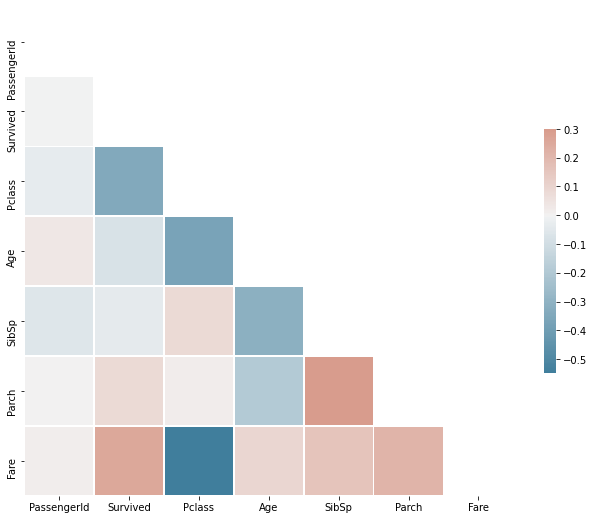

In [ ]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Fill Age: null values replace by random age between mean + std & mean-std

data = [train, test]

for dataset in data:
  mean = train['Age'].mean()
  std = train['Age'].std()
  filled_age = np.random.randint(mean-std, mean+std, dataset['Age'].isnull().sum())

  filled_age_list = dataset['Age'].copy()
  filled_age_list[np.isnan(filled_age_list)] = filled_age
  dataset['Age'] = filled_age_list

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

In [ ]:
# Fare: Replace null values with mean+std & mean-std

mean = train['Fare'].mean()
std = train['Fare'].std()
filled_fare = np.random.randint(mean-std, mean+std, test['Fare'].isnull().sum())

filled_fare_list = test['Fare'].copy()
filled_fare_list[np.isnan(filled_fare_list)] = filled_fare
test['Fare'] = filled_fare_list

In [ ]:
#test.info()

In [ ]:
### Embarked: Using mode to replace null embarked

embarked_mode = train['Embarked'].mode()
for dataset in data:
  dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)

In [ ]:
#train.info(), test.info()

In [ ]:
### Alone or with family: Create new feature called relative, which is a combination of parch and sibsp

for dataset in data:
  dataset['Relative'] = dataset['Parch'] + dataset['SibSp']
  status = []
  for datapoint in dataset['Relative']:
    if datapoint > 0:
      status.append(1)
    else:
      status.append(0)

  dataset['Relative'] = status

In [ ]:
### Name alternative

for dataset in data:

  Name_title = []

  for name in dataset['Name']:
    if "Mr." in name:
      Name_title.append("Mr.")
    elif "Mrs." in name:
      Name_title.append("Mrs.")
    elif "Ms." in name:
      Name_title.append("Miss.")
    elif "Rev." in name:
      Name_title.append("Rev.")
    elif "Miss." in name:
      Name_title.append("Miss.")
    elif "Dr." in name:
      Name_title.append("Dr.")
    elif "Master." in name:
      Name_title.append("Master.")
    elif "Major." in name:
      Name_title.append("Major.")
    elif "Col." in name:
      Name_title.append("Col.")
    elif "Capt." in name:
      Name_title.append("Capt.")
    elif "Don." in name:
      Name_title.append("Don.")
    else:
      Name_title.append("Others")

  dataset["Title"] = Name_title

In [ ]:
train[train.Title == "Master."]["Age"].min()

0.42

In [ ]:
for dataset in data:
  Age_range = []
  for age in dataset['Age']:
    if age <= 15:
      Age_range = "Under 15"
    elif age <= 35:
      Age_range = "Under 35"
    elif age < 60:
      Age_range = "Under 60"
    else:
      Age_range = "More than 60"
  #dataset["Age_range"] = Age_range

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relative,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr.


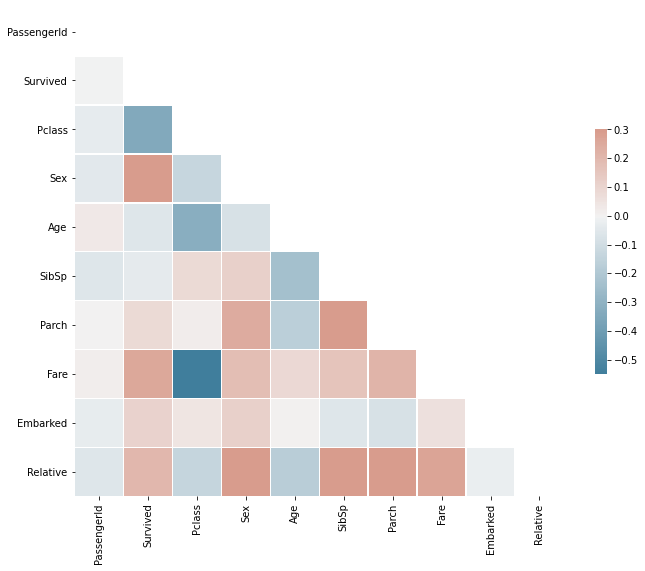

In [ ]:
## Replot the correlation chart.

train_plotted = train.copy()

train_plotted['Sex'] = train_plotted.Sex.map({'male':0, 'female':1})
train_plotted['Embarked'] = train_plotted.Embarked.map({'S':1, 'C':2, 'Q':3})

corr = train_plotted.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#### Numerical features scaling
from sklearn.preprocessing import StandardScaler

train_copy = train.copy().drop(['Survived'], axis = 1)
#train_num_features = list(train_copy.select_dtypes(include = ['int32', 'int64','float64']).columns)
train_num_features = ['PassengerId', 'Pclass', 'SibSp', 'Parch']
print(train_num_features)
scaler = StandardScaler()
train_scaled = train_copy

train_scaled[train_num_features] = scaler.fit_transform(train_scaled[train_num_features])

['PassengerId', 'Pclass', 'SibSp', 'Parch']


In [ ]:
test_copy = test.copy()#.drop(['Name', 'Cabin', 'PassengerId'], axis = 1)

#test_num_features = list(test_copy.select_dtypes(include = ['int32', 'int64','float64']).columns)
test_num_features = ['PassengerId', 'Pclass', 'SibSp', 'Parch']
scaler = StandardScaler()
test_scaled = test_copy

test_scaled[train_num_features] = scaler.fit_transform(test_scaled[train_num_features])

In [ ]:
train_scaled.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relative,Title
0,-1.730108,0.827377,"Braund, Mr. Owen Harris",male,22.0,0.432793,-0.473674,A/5 21171,7.2500,NaN,S,1,Mr.
1,-1.726220,-1.566107,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,0.432793,-0.473674,PC 17599,71.2833,C85,C,1,Mrs.
2,-1.722332,0.827377,"Heikkinen, Miss. Laina",female,26.0,-0.474545,-0.473674,STON/O2. 3101282,7.9250,NaN,S,0,Miss.
3,-1.718444,-1.566107,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,0.432793,-0.473674,113803,53.1000,C123,S,1,Mrs.
4,-1.714556,0.827377,"Allen, Mr. William Henry",male,35.0,-0.474545,-0.473674,373450,8.0500,NaN,S,0,Mr.


In [ ]:
test_scaled.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relative,Title
0,-1.727912,0.873482,"Kelly, Mr. James",male,34.5,-0.499470,-0.400248,330911,7.8292,NaN,Q,0,Mr.
1,-1.719625,0.873482,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,0.616992,-0.400248,363272,7.0000,NaN,S,1,Mrs.
2,-1.711337,-0.315819,"Myles, Mr. Thomas Francis",male,62.0,-0.499470,-0.400248,240276,9.6875,NaN,Q,0,Mr.
3,-1.703050,0.873482,"Wirz, Mr. Albert",male,27.0,-0.499470,-0.400248,315154,8.6625,NaN,S,0,Mr.
4,-1.694763,0.873482,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,0.616992,0.619896,3101298,12.2875,NaN,S,1,Mrs.


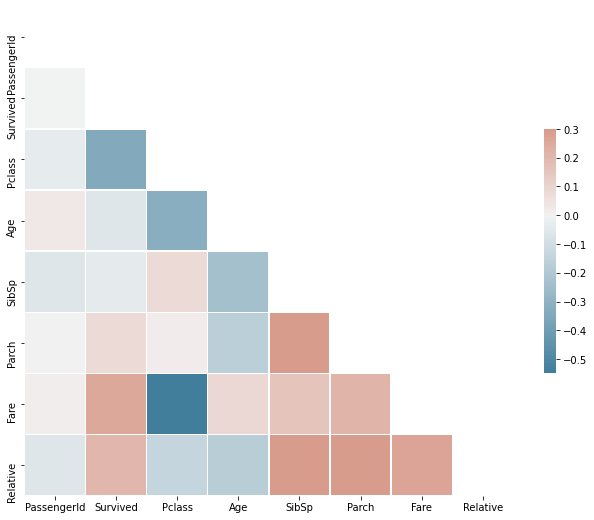

In [ ]:
#### PLOTTING THE CORRELATION TO CHECK IF THERE IS ANY DIFFERENT BEFORE AND AFTER STANDARD SCALING

train_num_features_corr = list(train.select_dtypes(include = ['int32', 'int64','float64']).columns)
scaler = StandardScaler()
train_scaled_corr = train.copy()

train_scaled_corr[train_num_features_corr] = scaler.fit_transform(train_scaled_corr[train_num_features_corr])


corr = train_scaled_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#### transform categorical var

#encode_col = list(train_copy.select_dtypes(include = ['object']).columns)
encode_col = ['Name', 'Sex', 'Age', 'Ticket', 'Cabin', 'Embarked', 'Relative','Title', 'Fare']#, 'Age_range']
for i in encode_col:
  train_scaled = pd.concat([train_scaled, pd.get_dummies(train_scaled[i], prefix = i)], axis = 1)
  train_scaled.drop(i, axis = 1, inplace = True)

In [ ]:
#encode_col = list(test_copy.select_dtypes(include = ['object']).columns)
encode_col = ['Name', 'Sex', 'Age', 'Ticket', 'Cabin', 'Embarked', 'Relative','Title', 'Fare']#, 'Age_range']

for i in encode_col:
  test_scaled = pd.concat([test_scaled, pd.get_dummies(test_scaled[i], prefix = i)], axis = 1)
  test_scaled.drop(i, axis = 1, inplace = True)

# Get missing columns in the training test
missing_cols = set( train_scaled.columns ) - set( test_scaled.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_scaled[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_scaled = test_scaled[train_scaled.columns]

In [ ]:
test_scaled.shape, train_scaled.shape

((418, 2077), (891, 2077))

In [ ]:
train_scaled.head()

,PassengerId,Pclass,SibSp,Parch,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias","Name_Andersson, Miss. Ebba Iris Alfrida","Name_Andersson, Miss. Ellis Anna Maria","Name_Andersson, Miss. Erna Alexandra","Name_Andersson, Miss. Ingeborg Constanzia","Name_Andersson, Miss. Sigrid Elisabeth","Name_Andersson, Mr. Anders Johan","Name_Andersson, Mr. August Edvard (""Wennerstrom"")","Name_Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)","Name_Andreasson, Mr. Paul Edvin","Name_Andrew, Mr. Edgardo Samuel","Name_Andrews, Miss. Kornelia Theodosia","Name_Andrews, Mr. Thomas Jr","Name_Angle, Mrs. William A (Florence ""Mary"" Agnes Hughes)",...,Fare_73.5,Fare_75.25,Fare_76.2917,Fare_76.7292,Fare_77.2875,Fare_77.9583,Fare_78.2667,Fare_78.85,Fare_79.2,Fare_79.65,Fare_80.0,Fare_81.8583,Fare_82.1708,Fare_83.1583,Fare_83.475,Fare_86.5,Fare_89.1042,Fare_90.0,Fare_91.0792,Fare_93.5,Fare_106.425,Fare_108.9,Fare_110.8833,Fare_113.275,Fare_120.0,Fare_133.65,Fare_134.5,Fare_135.6333,Fare_146.5208,Fare_151.55,Fare_153.4625,Fare_164.8667,Fare_211.3375,Fare_211.5,Fare_221.7792,Fare_227.525,Fare_247.5208,Fare_262.375,Fare_263.0,Fare_512.3292
0,-1.730108,0.827377,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.726220,-1.566107,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.722332,0.827377,-0.474545,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.718444,-1.566107,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.714556,0.827377,-0.474545,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# METHOD 1: LOGISTIC REGRESSION

In [ ]:
train_scaled.head()

,PassengerId,Pclass,SibSp,Parch,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias","Name_Andersson, Miss. Ebba Iris Alfrida","Name_Andersson, Miss. Ellis Anna Maria","Name_Andersson, Miss. Erna Alexandra","Name_Andersson, Miss. Ingeborg Constanzia","Name_Andersson, Miss. Sigrid Elisabeth","Name_Andersson, Mr. Anders Johan","Name_Andersson, Mr. August Edvard (""Wennerstrom"")","Name_Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)","Name_Andreasson, Mr. Paul Edvin","Name_Andrew, Mr. Edgardo Samuel","Name_Andrews, Miss. Kornelia Theodosia","Name_Andrews, Mr. Thomas Jr","Name_Angle, Mrs. William A (Florence ""Mary"" Agnes Hughes)",...,Fare_73.5,Fare_75.25,Fare_76.2917,Fare_76.7292,Fare_77.2875,Fare_77.9583,Fare_78.2667,Fare_78.85,Fare_79.2,Fare_79.65,Fare_80.0,Fare_81.8583,Fare_82.1708,Fare_83.1583,Fare_83.475,Fare_86.5,Fare_89.1042,Fare_90.0,Fare_91.0792,Fare_93.5,Fare_106.425,Fare_108.9,Fare_110.8833,Fare_113.275,Fare_120.0,Fare_133.65,Fare_134.5,Fare_135.6333,Fare_146.5208,Fare_151.55,Fare_153.4625,Fare_164.8667,Fare_211.3375,Fare_211.5,Fare_221.7792,Fare_227.525,Fare_247.5208,Fare_262.375,Fare_263.0,Fare_512.3292
0,-1.730108,0.827377,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.726220,-1.566107,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.722332,0.827377,-0.474545,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.718444,-1.566107,0.432793,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.714556,0.827377,-0.474545,-0.473674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = train['Survived']
x = train_scaled

X_train,X_valid,y_train,y_valid = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
#Build logistic regression model:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=LogisticRegression(max_iter = 10000)
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred_train = lr.predict(X_train)
y_pred=lr.predict(X_valid)
print('Subtrain accuracy:', accuracy_score(y_pred_train,y_train))
print('Validation accuracy:', accuracy_score(y_valid,y_pred))

Subtrain accuracy: 0.9424157303370787
Validation accuracy: 0.8435754189944135


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_valid,y_pred)

array([[92, 13],
       [15, 59]])

# METHOD 2: DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(x,y,test_size=0.2,random_state=42)

dtc=DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_predict=dtc.predict(X_valid)

In [ ]:
confusion_matrix(y_valid,y_predict)

array([[90, 15],
       [17, 57]])

In [ ]:
accuracy_score(y_valid,y_predict)

0.8212290502793296

In [ ]:
from sklearn.metrics import classification_report as cr

In [ ]:
print(cr(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



# METHOD 3: RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rc

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(x,y,test_size=0.2,random_state=42)

rfc=rc()
rfc.fit(X_train,y_train)
rfc_y_pred=rfc.predict(X_valid)

In [ ]:
accuracy_score(y_valid,rfc_y_pred)

0.8156424581005587

In [ ]:
print(cr(y_valid,rfc_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



# SUBMISSION TO KAGGLE

In [ ]:
test_scaled.head()

,PassengerId,Pclass,SibSp,Parch,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias","Name_Andersson, Miss. Ebba Iris Alfrida","Name_Andersson, Miss. Ellis Anna Maria","Name_Andersson, Miss. Erna Alexandra","Name_Andersson, Miss. Ingeborg Constanzia","Name_Andersson, Miss. Sigrid Elisabeth","Name_Andersson, Mr. Anders Johan","Name_Andersson, Mr. August Edvard (""Wennerstrom"")","Name_Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)","Name_Andreasson, Mr. Paul Edvin","Name_Andrew, Mr. Edgardo Samuel","Name_Andrews, Miss. Kornelia Theodosia","Name_Andrews, Mr. Thomas Jr","Name_Angle, Mrs. William A (Florence ""Mary"" Agnes Hughes)",...,Fare_73.5,Fare_75.25,Fare_76.2917,Fare_76.7292,Fare_77.2875,Fare_77.9583,Fare_78.2667,Fare_78.85,Fare_79.2,Fare_79.65,Fare_80.0,Fare_81.8583,Fare_82.1708,Fare_83.1583,Fare_83.475,Fare_86.5,Fare_89.1042,Fare_90.0,Fare_91.0792,Fare_93.5,Fare_106.425,Fare_108.9,Fare_110.8833,Fare_113.275,Fare_120.0,Fare_133.65,Fare_134.5,Fare_135.6333,Fare_146.5208,Fare_151.55,Fare_153.4625,Fare_164.8667,Fare_211.3375,Fare_211.5,Fare_221.7792,Fare_227.525,Fare_247.5208,Fare_262.375,Fare_263.0,Fare_512.3292
0,-1.727912,0.873482,-0.499470,-0.400248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.719625,0.873482,0.616992,-0.400248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.711337,-0.315819,-0.499470,-0.400248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.703050,0.873482,-0.499470,-0.400248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-1.694763,0.873482,0.616992,0.619896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Columns: 2077 entries, PassengerId to Fare_512.3292
dtypes: float64(4), int64(1699), uint8(374)
memory usage: 5.6 MB


In [ ]:
predictions = lr.predict(test_scaled)

submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

In [ ]:
filename = 'titanic_pred40.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: titanic_pred40.csv
